# Reprojecting to other coordinate system:

## Setting up:

In [42]:
# run script that installs missing libraries
#! chmod 755 scripts.sh
#! ./scripts.sh

### Imports

In [1]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs

import pyproj
from pyproj import Transformer
from google.cloud import storage

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [2]:
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

# Google cloud
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

In [3]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

## Read data

### GCM:

In [6]:
# open from google cloud
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3.zarr'
dg = xr.open_zarr('gs://'+globalName, decode_times=False)

# rename variables
dg = dg.rename({'TIME2':'time', 'PLEV12_15':'plev','LAT':'lat', 'LON':'lon'})

# get starting date and units of dataset
units, reference_date = dg.time.attrs['units'].split('since')
print('Units: {} and reference date: {} of global dataset'.format(units, reference_date))

# set reference date, add first value in time array
START = datetime(1950,1,15,0,0,0)+timedelta(days=dg.time[0].values*30)

print('First date in time array: {}'.format(START))

# Correct the time by having a yearly range from the starting date till 2100
# Need to assign new coordinates so that the coordinates of values also change
dg = dg.assign_coords(time=pd.date_range(start=START, periods=dg.sizes['time'], freq='12M'))
dg.load()

Units: month(360days)  and reference date:  1950-01-15 00:00:00 of global dataset
First date in time array: 1950-06-29 00:00:00


<xarray.Dataset>
Dimensions:         (lat: 144, lon: 192, plev: 4, bnds: 2, time: 151)
Coordinates:
  * lat             (lat) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, lat, lon) float32 232.7 232.7 ... 267.7 267.7
    TAS             (time, lat, lon) float32 225.6 225.6 225.5 ... 271.3 271.3
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, lat, lon) float32 0.6384 0.6994 ... -2.163
    VA              (time, plev, lat, lon) float32 -1.574 -1.541 ... -0.3436
    ZG              (time, plev, lat, lon) float32 4.961e+03 ... 1.368e+03
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

#### Define antarctica region

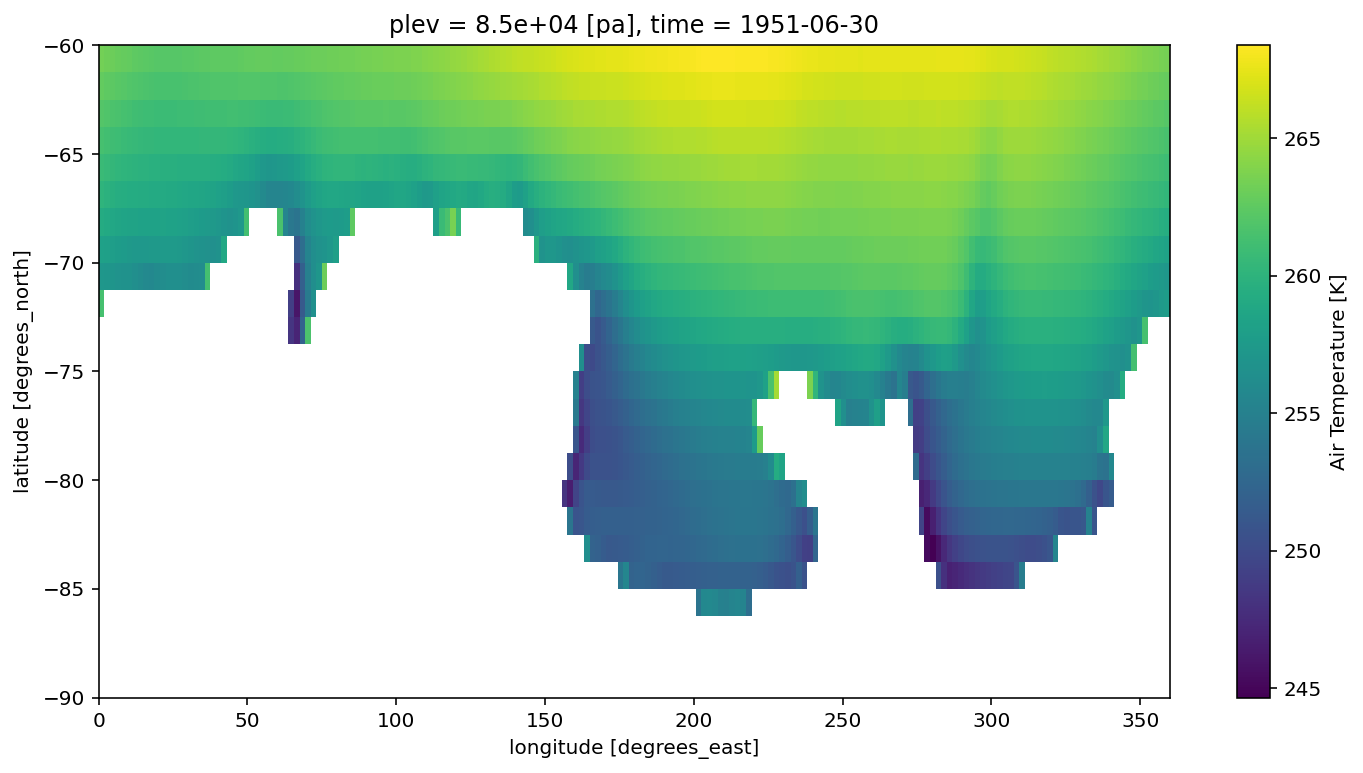

In [7]:
# define antarctica as 90° S to 60° S in latitude and full longitude
nlimit=-60
lat = dg.lat.sel(lat=slice(-90,nlimit))
lon = dg.lon

antarctica = dg.sel(lat=slice(-90,nlimit))
antarctica.TA.isel(time=1, plev = 3).plot(x="lon")

In [9]:
# Define GCM
GCM = antarctica.sortby(["lat", "lon","time"])

print('[GCM original] lon: {}° -> {}° and lat: {}° -> {}°'.format(GCM.lon.min().data, 
                                                                     GCM.lon.max().data, 
                                                                     GCM.lat.min().data, 
                                                                     GCM.lat.max().data))
GCM

[GCM original] lon: 0.9375° -> 359.0625° and lat: -89.375° -> -60.625°


<xarray.Dataset>
Dimensions:         (lat: 24, lon: 192, plev: 4, bnds: 2, time: 151)
Coordinates:
  * lat             (lat) float64 -89.38 -88.12 -86.88 ... -63.12 -61.88 -60.62
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, lat, lon) float32 232.7 232.7 ... 266.4 266.3
    TAS             (time, lat, lon) float32 225.6 225.6 225.5 ... 271.4 271.5
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, lat, lon) float32 0.6384 0.6994 ... 8.458 8.423
    VA              (time, plev, lat, lon) float32 -1.574 -1.541 ... 2.16 2.111
    ZG              (time, plev, lat, lon) float32 4.961e+03 ... 1.176e+03
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

### RCM:

In [10]:
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
RCM = dsr.rename({'X':'x', 'Y':'y','TIME':'time'})
RCM_xy = RCM.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
RCM_xy['x'] = RCM_xy.x*1000
RCM_xy['y'] = RCM_xy.y*1000
RCM_xy.x.attrs['units'] = 'm'
RCM_xy.y.attrs['units'] = 'm'

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(RCM_xy.x.max().data, 
                                                                     RCM_xy.x.min().data, 
                                                                     RCM_xy.y.max().data, 
                                                                     RCM_xy.y.min().data))
RCM_xy.load()

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


<xarray.Dataset>
Dimensions:      (time: 121, y: 148, x: 176, SECTOR1_1: 1, bnds: 2)
Coordinates:
  * SECTOR1_1    (SECTOR1_1) float32 1.0
  * time         (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Dimensions without coordinates: bnds
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    RU           (time, SECTOR1_1, y, x) float32 inf inf inf inf ... inf inf inf
    SF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SMB          (time, SECTOR1_1, y, x) float64 nan nan nan nan ... nan nan nan
    SU           (time, SECTOR1_1, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TIME_bnds    (time, bnds) datetime64[ns] 1980-01-01 ... 2101-01-01
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    contact:           ckittel@uliege.be
    creation_date:     2021-01-23-T13:24:17Z
    driving_model_id:  ACCESS1.3
    institute_id:      ULg
    institution:       University of Liege - Belgium
    reference:         http://www.climato.be
    tracking_id:       ddbf4239bdd46d1127a1bf5625cf2bc0

## Interpolate RCM x/y -> lat/lon:

Transform RCM to lat/lon on GCM like grid.

In [11]:
# Define the source and target projections
source_crs = pyproj.CRS(3031) # Coordinate system of the file
target_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system

# GCM -epsg:4326
GCM_latlon = GCM.rio.write_crs(target_crs)
GCM_latlon.attrs['crs']  = target_crs

print('Shape of original data, time: {}, lat: {}, lon: {}'.format(GCM_latlon.TAS.shape[0],
                                                                  GCM_latlon.TAS.shape[1],
                                                                  GCM_latlon.TAS.shape[2]))

Shape of original data, time: 151, lat: 24, lon: 192


/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
# Create a grid of lat/lon values for the lat/lon grid of GCM over antarctic
lonmesh, latmesh = np.meshgrid(GCM.lon, GCM.lat)

# Create a pyproj.Transformer to transform each point 
# in lonmesh and lastmesh into a location in the polar coordinates 
latlon_to_polar = pyproj.Transformer.from_crs(target_crs, source_crs)

# polar coordinates from lat-lon
x_om2, y_om2 = latlon_to_polar.transform(lonmesh, latmesh)

# Use the xarray interp method to find the nearest locations 
# for each transformed point
# To do this need to create xarray.DataArray for the coordinates with matching dimensions.
x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))

In [13]:
# Interpolate
RCM_xy_int = RCM_xy.interp({'x':x_om2, 'y':y_om2}, method='nearest').load()

# Assign new coordinates
RCM_latlon = RCM_xy_int.assign_coords({'lon': (('lon'), GCM_latlon.lon.data), 
                                   'lat': (('lat'), GCM_latlon.lat.data)}).drop_vars(['x','y']).reset_coords()
RCM_latlon.load()

<xarray.Dataset>
Dimensions:      (time: 121, lat: 24, lon: 192, SECTOR1_1: 1, bnds: 2)
Coordinates:
  * SECTOR1_1    (SECTOR1_1) float32 1.0
  * time         (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * lon          (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat          (lat) float64 -89.38 -88.12 -86.88 ... -63.12 -61.88 -60.62
Dimensions without coordinates: bnds
Data variables:
    RF           (time, lat, lon) float32 0.0003484 0.0003484 ... nan nan
    RU           (time, SECTOR1_1, lat, lon) float32 0.0 0.0 0.0 ... nan nan nan
    SF           (time, lat, lon) float32 85.65 85.65 85.65 ... nan nan nan
    SMB          (time, SECTOR1_1, lat, lon) float64 89.72 89.72 ... nan nan
    SU           (time, SECTOR1_1, lat, lon) float32 -4.068 -4.068 ... nan nan
    TIME_bnds    (time, bnds) datetime64[ns] 1980-01-01 ... 2101-01-01
    spatial_ref  int64 0
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    contact:           ckittel@uliege.be
    creation_date:     2021-01-23-T13:24:17Z
    driving_model_id:  ACCESS1.3
    institute_id:      ULg
    institution:       University of Liege - Belgium
    reference:         http://www.climato.be
    tracking_id:       ddbf4239bdd46d1127a1bf5625cf2bc0

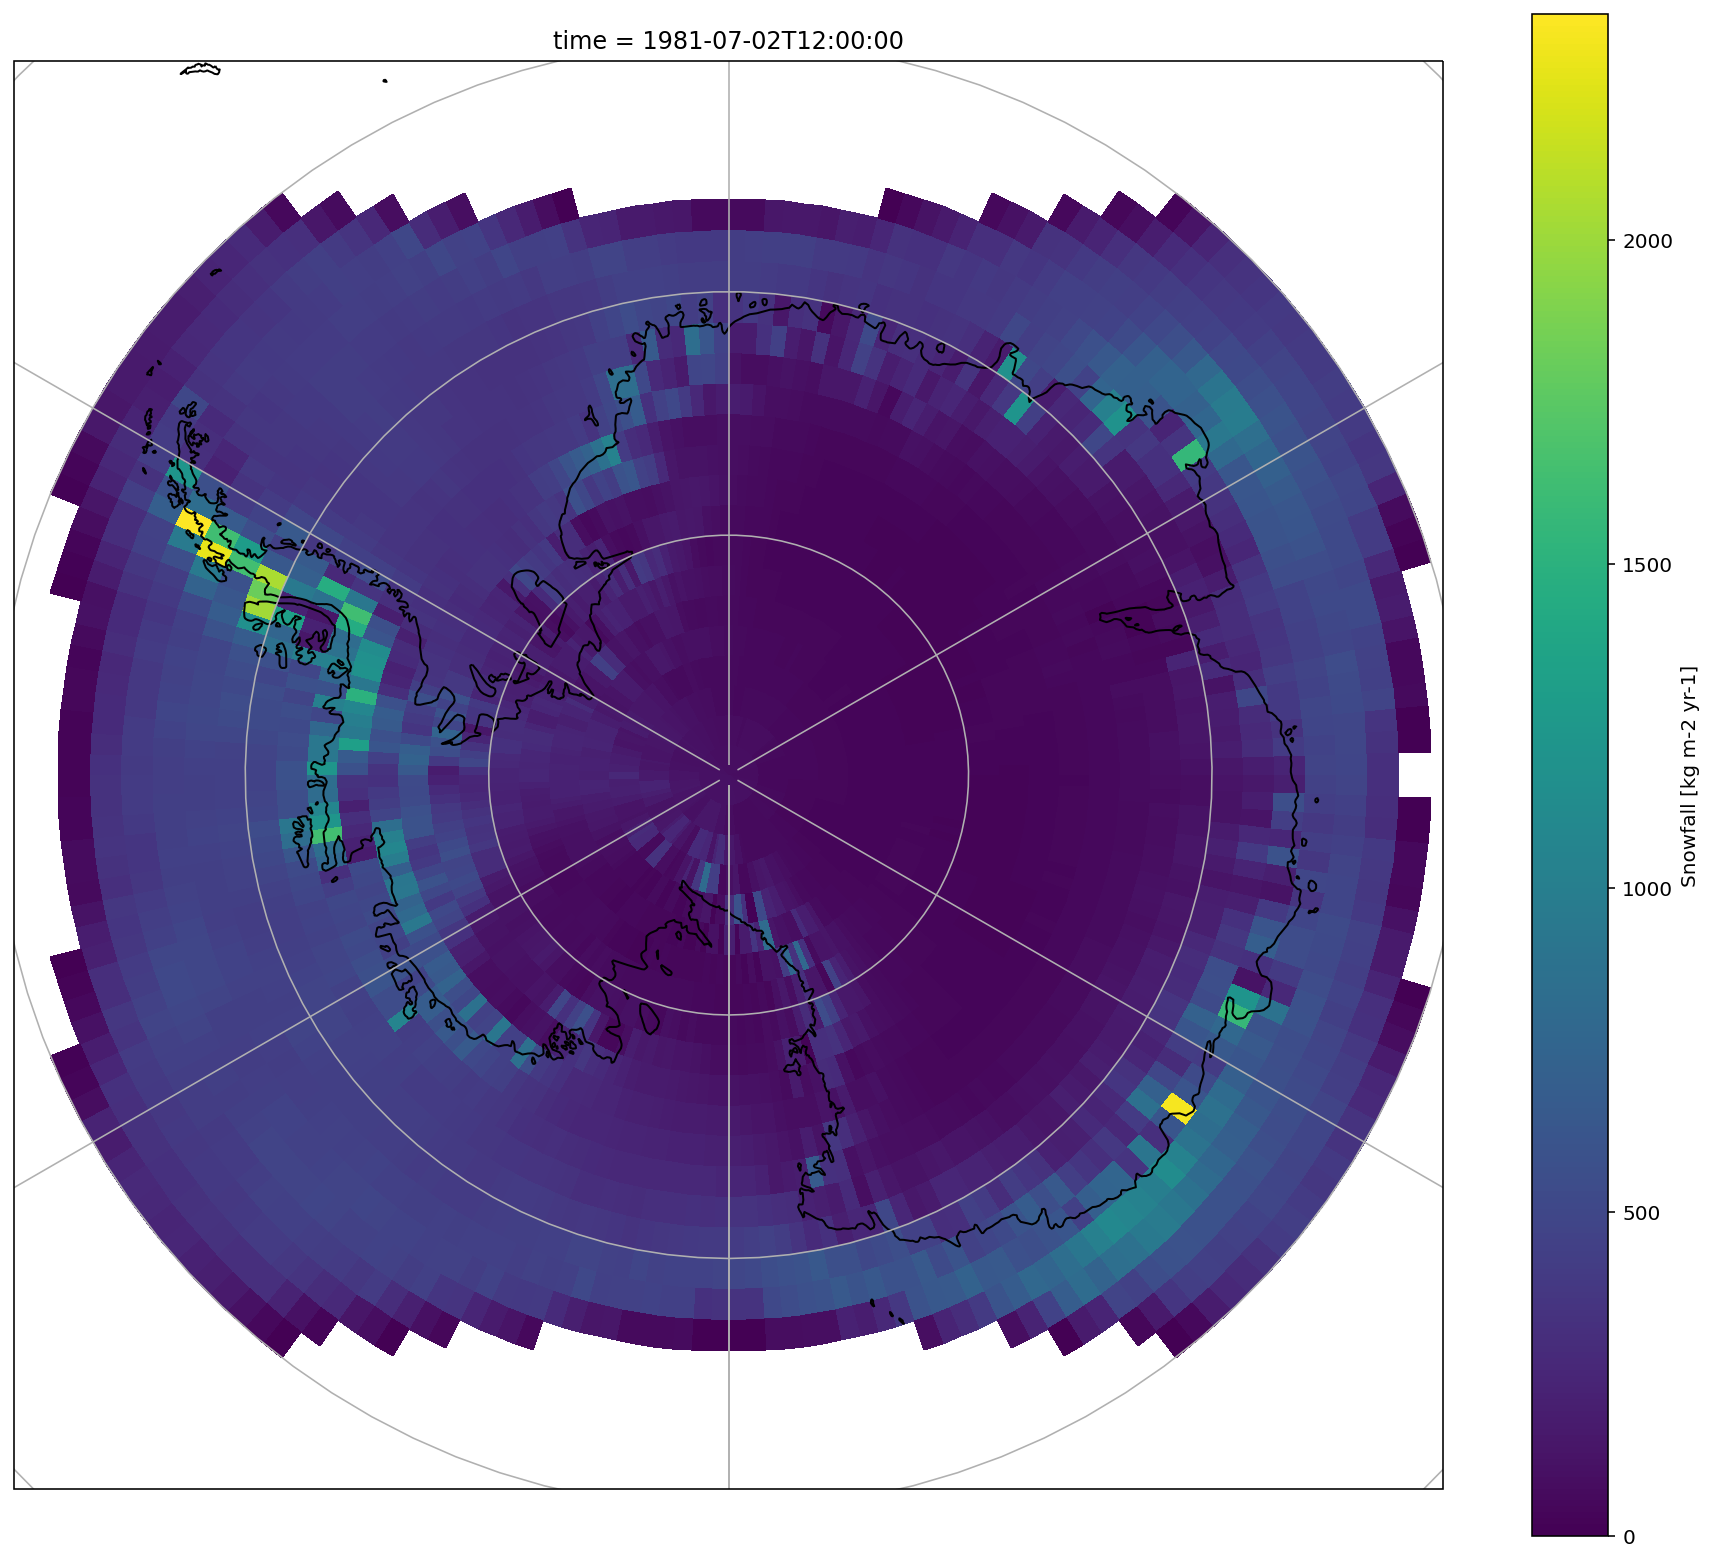

In [14]:
fig = plt.figure(figsize=(16, 14))
projection = ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

# map
ax.set_extent((-3333000, 3333000, -3333000, 3333000),
              crs=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')

ax.gridlines()
RCM_latlon.SF.isel(time=1).plot(ax=ax, x='lon', y='lat',
                              transform=ccrs.PlateCarree())  # data transform

### Save new projections to GC:

In [15]:
# Access file
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen-latlon.zarr'
RCM_latlon.attrs['crs'] = 4326
RCM_latlon.to_zarr('gs://'+localName, mode = 'w')

Test to see if saving data correctly worked

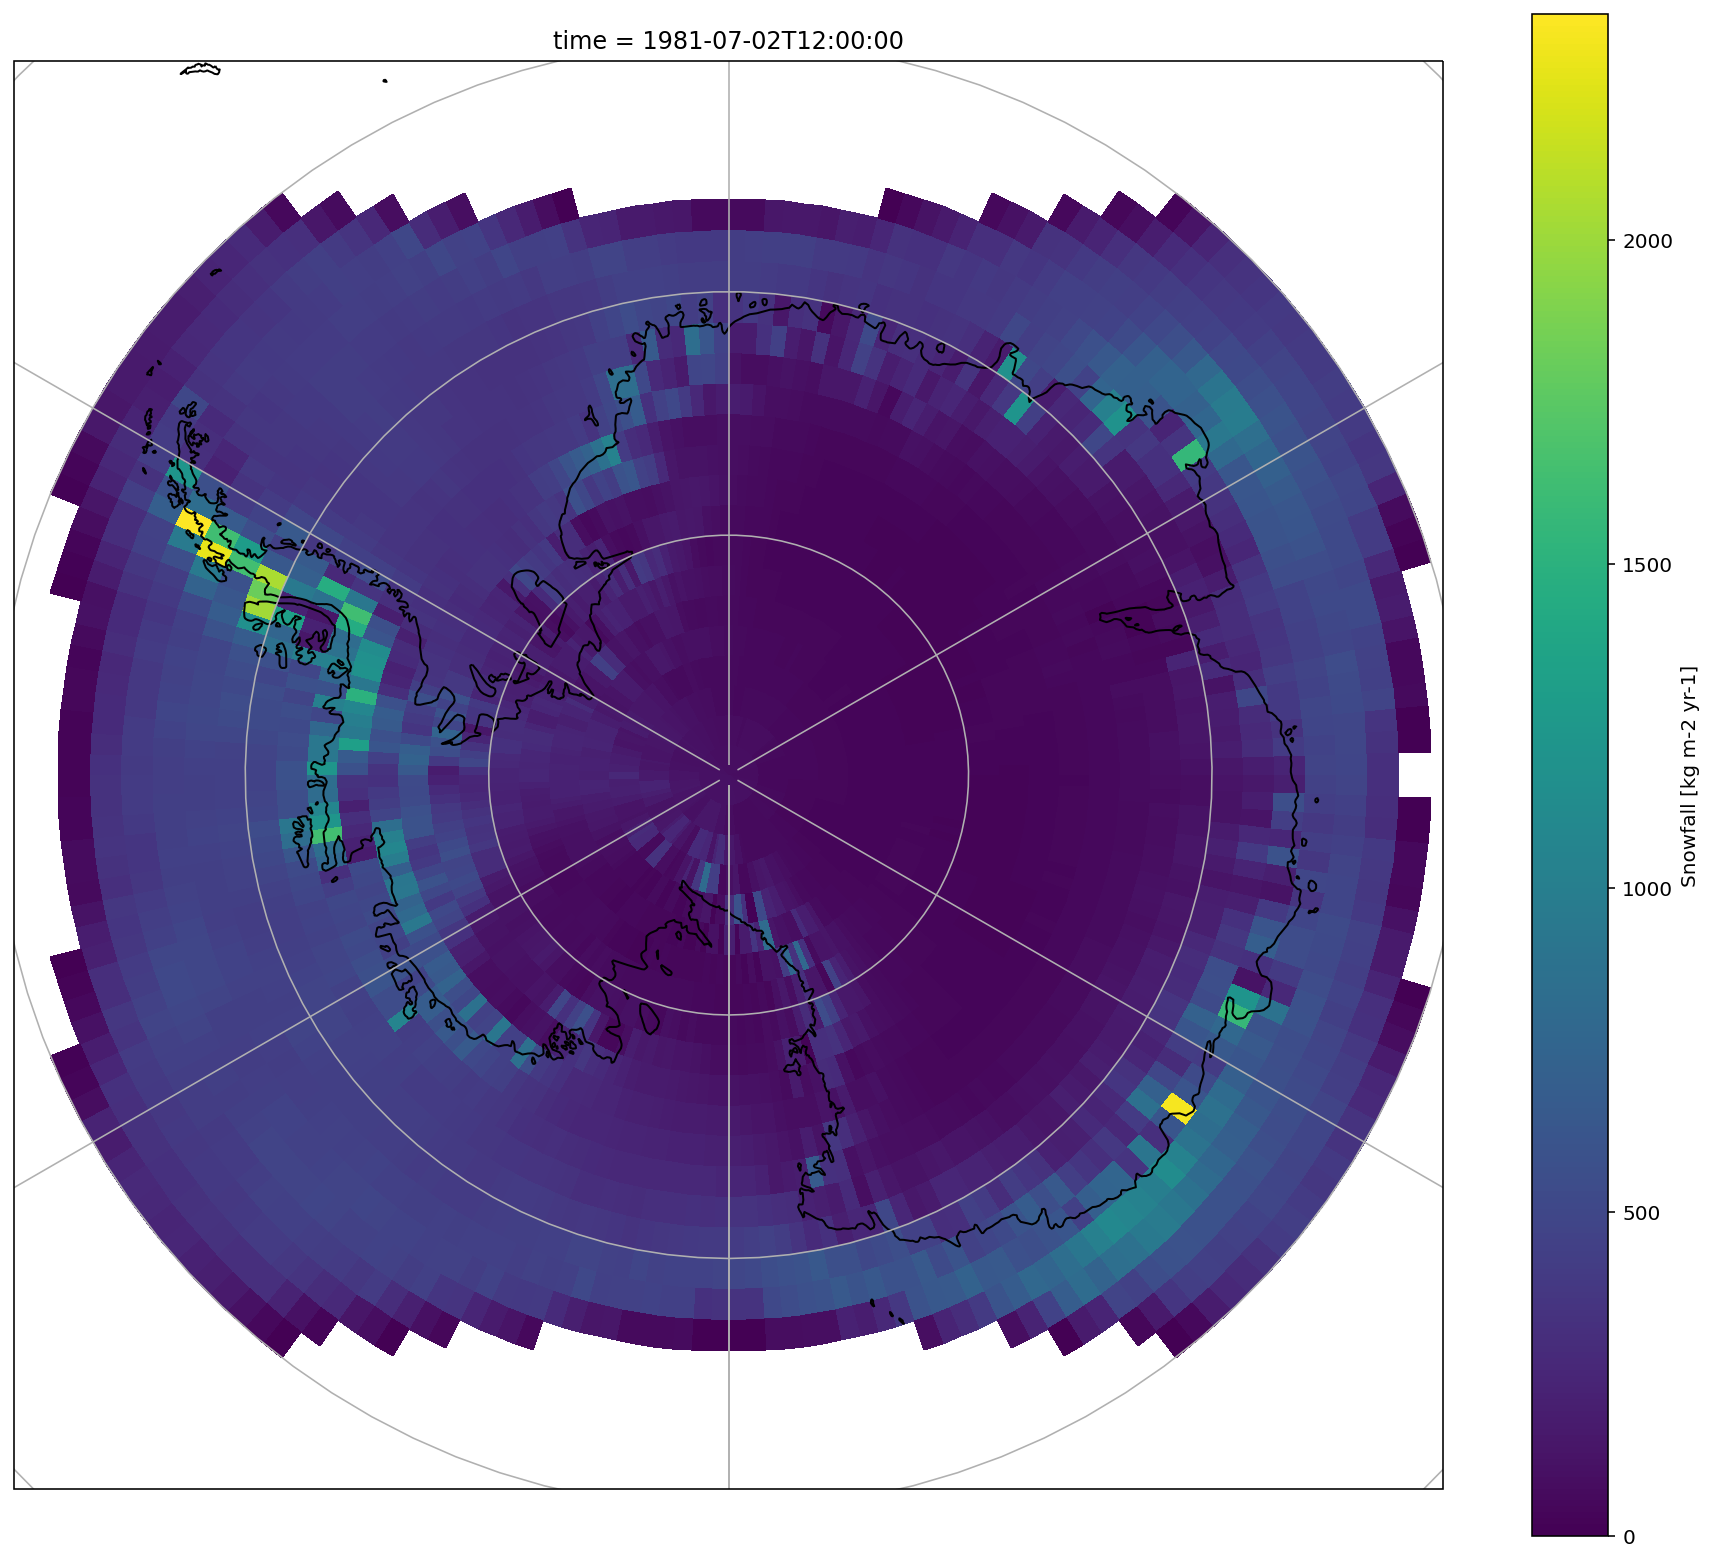

In [16]:
# open from google cloud
dg = xr.open_zarr('gs://'+localName)
dg.load()

fig = plt.figure(figsize=(16, 14))
projection = ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

# map
ax.set_extent((-3333000, 3333000, -3333000, 3333000),
              crs=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')

ax.gridlines()
dg.SF.isel(time=1).plot(ax=ax, x='lon', y='lat',
                              transform=ccrs.PlateCarree())  # data transform

## Interpolate GCM lat/lon -> x/y:
Transform GCM to x/y on RCM like grid. **Note: this upsamples the GCM to have the same resolution as RCM! Not a real coordiante transformation.**

Global data is in LON/LAT and need to go to Polar Stereographic (variant B) coordinates. Change GCM from lat/lon coordinates -> x/y polar stereographic coordinates.

Precise RCM coordinate information
char crs(char1) ;
              crs:long_name = "Polar Stereographic (variant B)" ;
              crs:grid_mapping_name = "polar_stereographic" ;
              crs:standard_name = "polar_stereographic" ;
              crs:authority = "EPSG:3031" ;
              crs:standard_parallel = -71.f ;
              crs:longitude_of_prime_meridian = 0.f ;
              crs:straight_vertical_longitude_from_pole = 0.f ;
              crs:semi_major_axis = 6378137.f ;
              crs:inverse_flattening = 298.2572f ;
              crs:latitude_of_projection_origin = -90.f ;
              crs:false_easting = 0.f ;
              crs:false_northing = 0.f

### Right plot:

In [17]:
# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
#RCM_xy.attrs['crs']  = target_crs
#SF_xy = SF_xy.rio.write_crs(target_crs)
print('Shape of GCM data, time: {}, lat: {}, lon: {}\n----------------\n'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}\n----------------\n'.format(RCM_xy.SF.shape[0],
                                                         RCM_xy.SF.shape[1],
                                                         RCM_xy.SF.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(RCM_xy.x, RCM_xy.y)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_right = GCM_latlon_int.assign_coords({'x': (('x'), RCM_xy.x.data), 
                                   'y': (('y'), RCM_xy.y.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_right.load()

Shape of GCM data, time: 151, lat: 24, lon: 192
----------------

Shape of RCM data, time: 121, x: 148, y: 176
----------------

Mesh shapes: (148, 176), (148, 176)
[Lat-lon mesh] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
----------------

[After transf] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
----------------

[TAS before interpolation] lon: 0.94° -> 359.06° and lat: -89.38° -> -60.62°
----------------

[TAS after interpolation] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
----------------



<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

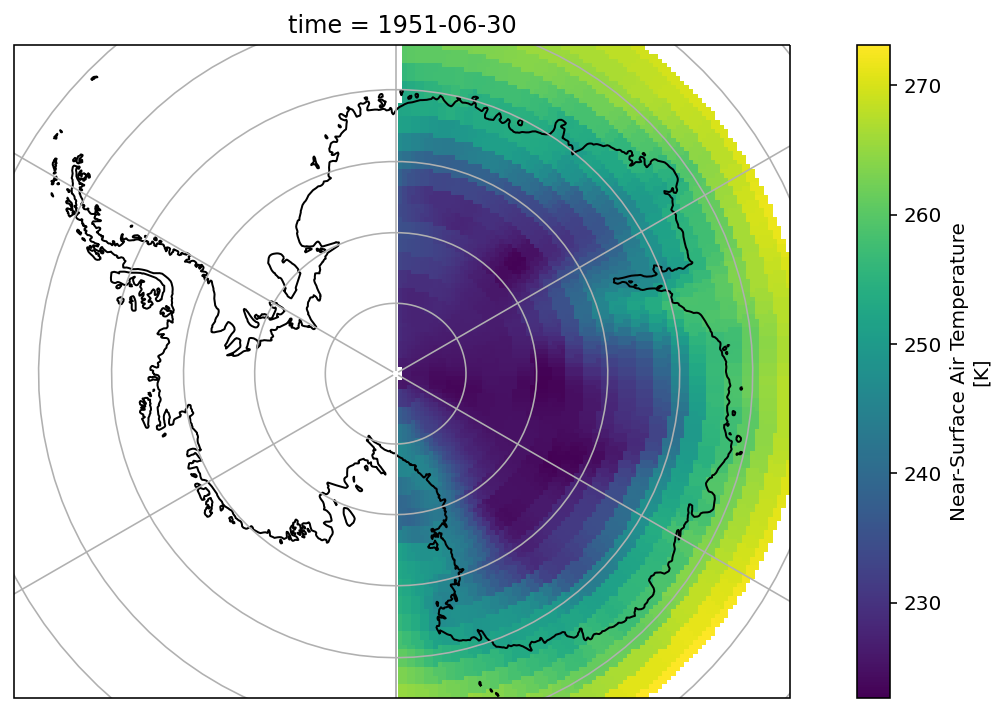

In [18]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_right.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

### Left plot:

In [19]:
# ----------- Transform GCM ----------
# Change all longitude coordinates to map from -180° -> 180°
GCM_transf = GCM.copy()
GCM_transf['lon'] = GCM_transf.lon-180
print('[After transf] lon: {}° -> {}° and lat: {}° -> {}°\n----------------\n'.format(GCM_transf.lon.min().data, 
                                                                     GCM_transf.lon.max().data, 
                                                                     GCM_transf.lat.min().data, 
                                                                     GCM_transf.lat.max().data))
# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM_transf.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
#SF_xy.attrs['crs']  = target_crs
#SF_xy = SF_xy.rio.write_crs(target_crs)
print('Shape of GCM data, time: {}, lat: {}, lon: {}\n----------------\n'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}\n----------------\n'.format(RCM_xy.SF.shape[0],
                                                         RCM_xy.SF.shape[1],
                                                         RCM_xy.SF.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(RCM_xy.x, RCM_xy.y)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# Transform lat lon mesh to get left part, add 180° to longitude
lon_om2 = lon_om2+180

print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_left = GCM_latlon_int.assign_coords({'x': (('x'), RCM_xy.x.data), 
                                   'y': (('y'), RCM_xy.y.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_left.load()

[After transf] lon: -179.0625° -> 179.0625° and lat: -89.375° -> -60.625°
----------------

Shape of GCM data, time: 151, lat: 24, lon: 192
----------------

Shape of RCM data, time: 121, x: 148, y: 176
----------------

Mesh shapes: (148, 176), (148, 176)
[Lat-lon mesh] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
----------------

[After transf] lon: 0.00° -> 359.22° and lat: -90.00° -> -53.91°
----------------

[TAS before interpolation] lon: -179.06° -> 179.06° and lat: -89.38° -> -60.62°
----------------

[TAS after interpolation] lon: 0.00° -> 359.22° and lat: -90.00° -> -53.91°
----------------



<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

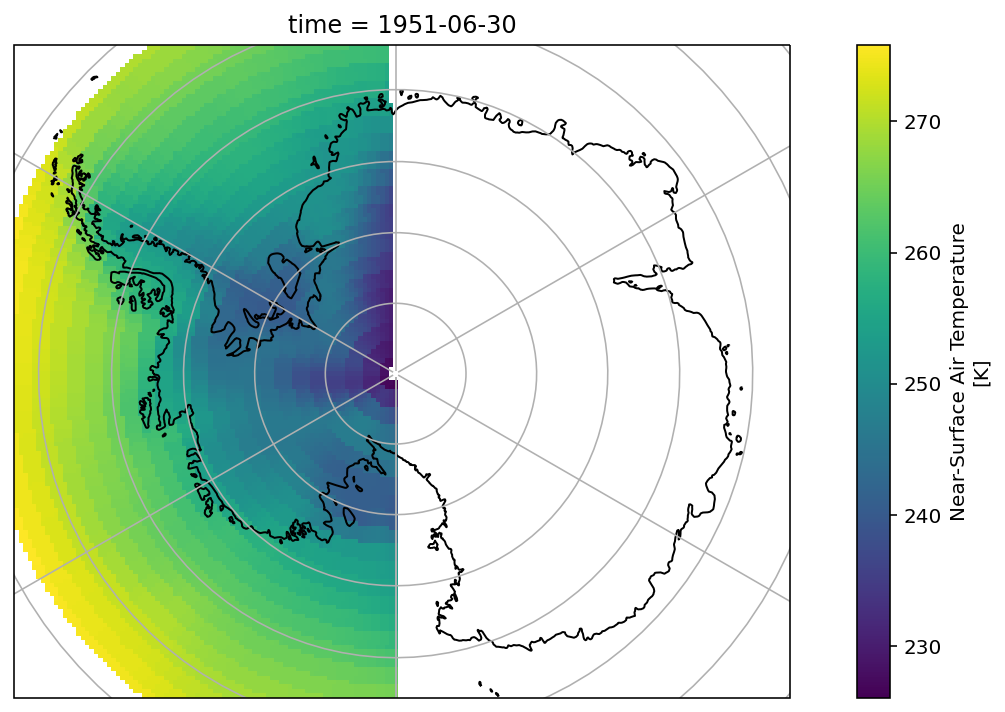

In [20]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_left.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

### Assemble two parts:

<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

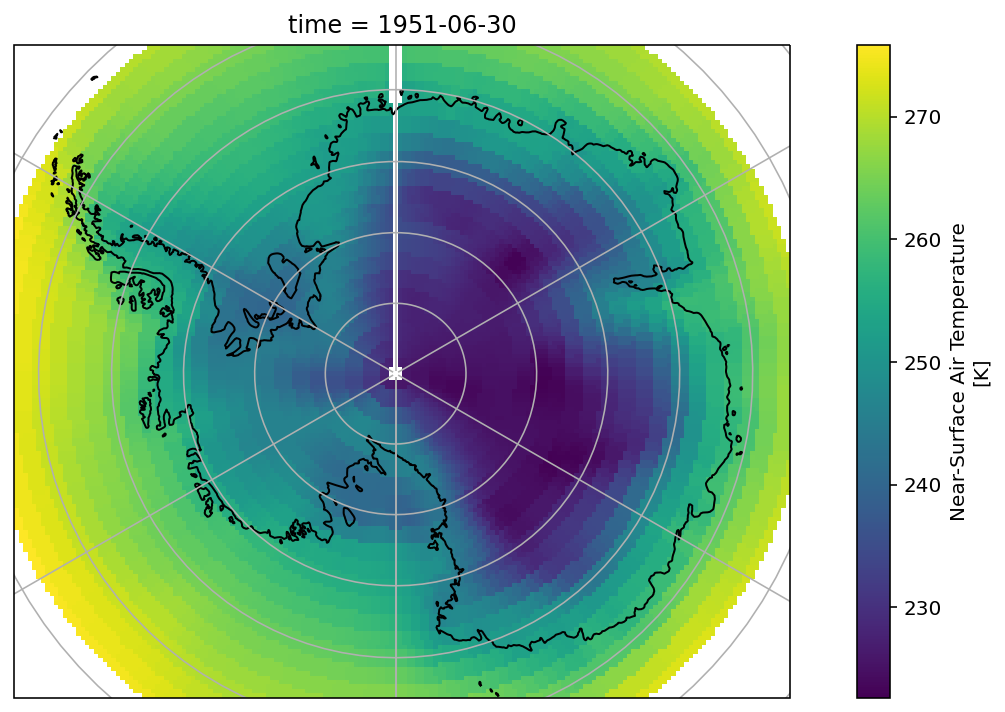

In [21]:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()
GCM_xy.load()

## Transform GCM lat/lon -> x/y:

Want to downsample RCM grid so that it goes from resolution of 35km to 150km

### Create downsampled RCM grid:
To change GCM resolution from degrees to km use formula:

x = deg_lon * distance between lon lines at point

y = deg_lat * distance between lat lines at point

Take d(lon) at -60°lat is 55km and d(lat) at -60°lat is 110km ([Link](https://stevemorse.org/nearest/distance.php))

Then x = 68km and y = 206km

In [22]:
# Load RCM grid
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
SF = dsr.SF
SF = SF.rename({'X':'x', 'Y':'y','TIME':'time'})
SF.load()

x_lower, x_upper = SF.x.min().data, SF.x.max().data
y_lower, y_upper = SF.y.min().data, SF.y.max().data

print('Max and min values of x: {0:.2f}km -> {1:.2f}km and y: {2:.2f}km -> {3:.2f}km \n----------------\n'.format(SF.x.min().data, 
                                                                     SF.x.max().data, 
                                                                     SF.y.min().data, 
                                                                     SF.y.max().data))
print_raster(SF)

Max and min values of x: -3010.00km -> 3115.00km and y: -2555.00km -> 2590.00km 
----------------

shape: (148, 176)
resolution: (35.00000279017857, 35.0)
bounds: (-3027.5002455357144, 2607.5, 3132.5002455357144, -2572.5)
CRS: None



In [23]:
# Downsample to new resolution
# original resolution 35km between each x-cell, want to go to 68km 
x_res_new = 68
y_res_new = 206

factor_x = x_res_new/35
factor_y = y_res_new/35

# Downsample:
SF['x'] = SF.x*factor_x
SF['y'] = SF.y*factor_y

print('Max and min values of x: {0:.2f}km -> {1:.2f}km and y: {2:.2f}km -> {3:.2f}km \n----------------\n'.format(SF.x.min().data, 
                                                                     SF.x.max().data, 
                                                                     SF.y.min().data, 
                                                                     SF.y.max().data))
print_raster(SF)

Max and min values of x: -5848.00km -> 6052.00km and y: -15038.00km -> 15244.00km 
----------------

shape: (148, 176)
resolution: (68.00000558035714, 205.99998671343536)
bounds: (-5882.000491071429, 15346.999016794218, 6086.000491071429, -15140.999016794218)
CRS: None



In [24]:
# Restrict new upsampled grid so that it lies in the original max and min bounds
cut_X = SF.x[(SF.x<=x_upper)&(SF.x>=x_lower)]
cut_Y = SF.y[(SF.y<=y_upper)&(SF.y>=y_lower)]

print('Max and min values of cut downsampled grid x: {0:.2f}km -> {1:.2f}km and y: {2:.2f}km -> {3:.2f}km'.format(cut_X.min().data, 
                                                                     cut_X.max().data, 
                                                                     cut_Y.min().data, 
                                                                     cut_Y.max().data))

# and change to meters
gridx = cut_X*1000
gridy = cut_Y*1000

Max and min values of cut downsampled grid x: -2992.00km -> 3060.00km and y: -2472.00km -> 2472.00km


In [25]:
gridx.shape, gridy.shape

((90,), (25,))

### Interpolate GCM on downsampled RCM grid:

#### Right plot

In [26]:
# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
print('Shape of GCM data, time: {}, lat: {}, lon: {}\n----------------\n'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}\n----------------\n'.format(RCM_xy.SF.shape[0],
                                                         RCM_xy.SF.shape[1],
                                                         RCM_xy.SF.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(gridx, gridy)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_right = GCM_latlon_int.assign_coords({'x': (('x'), gridx.data), 
                                   'y': (('y'), gridy.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_right.load()

Shape of GCM data, time: 151, lat: 24, lon: 192
----------------

Shape of RCM data, time: 121, x: 148, y: 176
----------------

Mesh shapes: (25, 90), (25, 90)
[Lat-lon mesh] lon: -180.00° -> 178.42° and lat: -90.00° -> -54.89°
----------------

[After transf] lon: -180.00° -> 178.42° and lat: -90.00° -> -54.89°
----------------

[TAS before interpolation] lon: 0.94° -> 359.06° and lat: -89.38° -> -60.62°
----------------

[TAS after interpolation] lon: -180.00° -> 178.42° and lat: -90.00° -> -54.89°
----------------



<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 25, x: 90)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y               (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

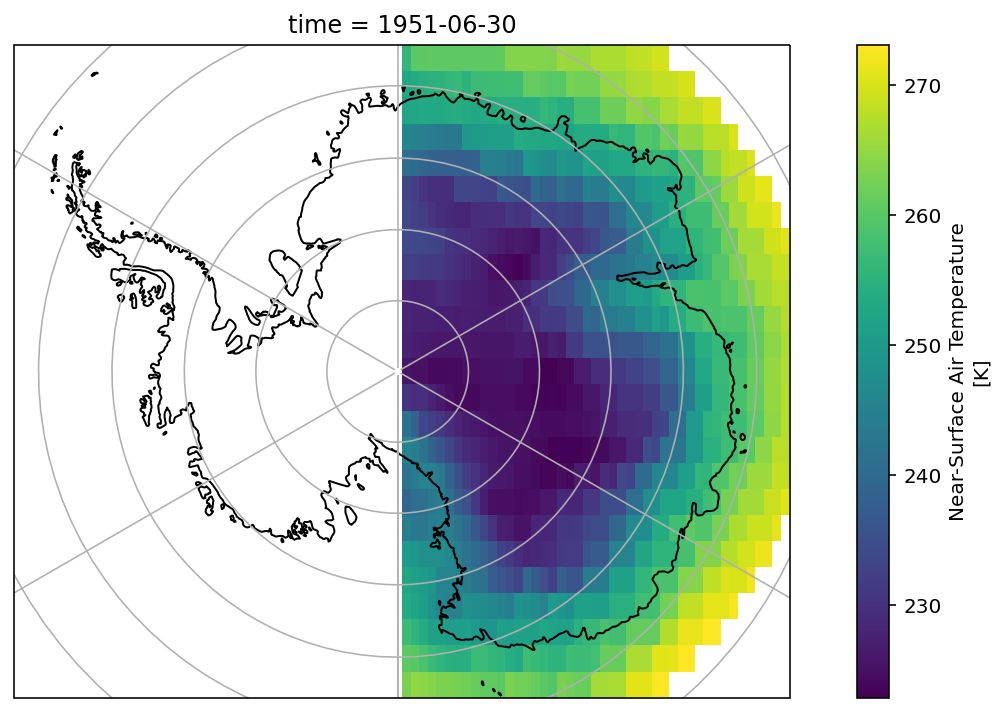

In [27]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_right.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

#### Left plot:

In [28]:
# ----------- Transform GCM ----------
# Change all longitude coordinates to map from -180° -> 180°
GCM_transf = GCM.copy()
GCM_transf['lon'] = GCM_transf.lon-180
print('[After transf] lon: {}° -> {}° and lat: {}° -> {}°\n----------------\n'.format(GCM_transf.lon.min().data, 
                                                                     GCM_transf.lon.max().data, 
                                                                     GCM_transf.lat.min().data, 
                                                                     GCM_transf.lat.max().data))
# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM_transf.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
#SF_xy.attrs['crs']  = target_crs
#SF_xy = SF_xy.rio.write_crs(target_crs)
print('Shape of GCM data, time: {}, lat: {}, lon: {}\n----------------\n'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}\n----------------\n'.format(RCM_xy.SF.shape[0],
                                                         RCM_xy.SF.shape[1],
                                                         RCM_xy.SF.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from downsampled RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(gridx, gridy)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# Transform lat lon mesh to get left part, add 180° to longitude
lon_om2 = lon_om2+180

print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°\n----------------\n'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_left = GCM_latlon_int.assign_coords({'x': (('x'), gridx.data), 
                                   'y': (('y'), gridy.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_left.load()

[After transf] lon: -179.0625° -> 179.0625° and lat: -89.375° -> -60.625°
----------------

Shape of GCM data, time: 151, lat: 24, lon: 192
----------------

Shape of RCM data, time: 121, x: 148, y: 176
----------------

Mesh shapes: (25, 90), (25, 90)
[Lat-lon mesh] lon: -180.00° -> 178.42° and lat: -90.00° -> -54.89°
----------------

[After transf] lon: 0.00° -> 358.42° and lat: -90.00° -> -54.89°
----------------

[TAS before interpolation] lon: -179.06° -> 179.06° and lat: -89.38° -> -60.62°
----------------

[TAS after interpolation] lon: 0.00° -> 358.42° and lat: -90.00° -> -54.89°
----------------



<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 25, x: 90)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y               (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

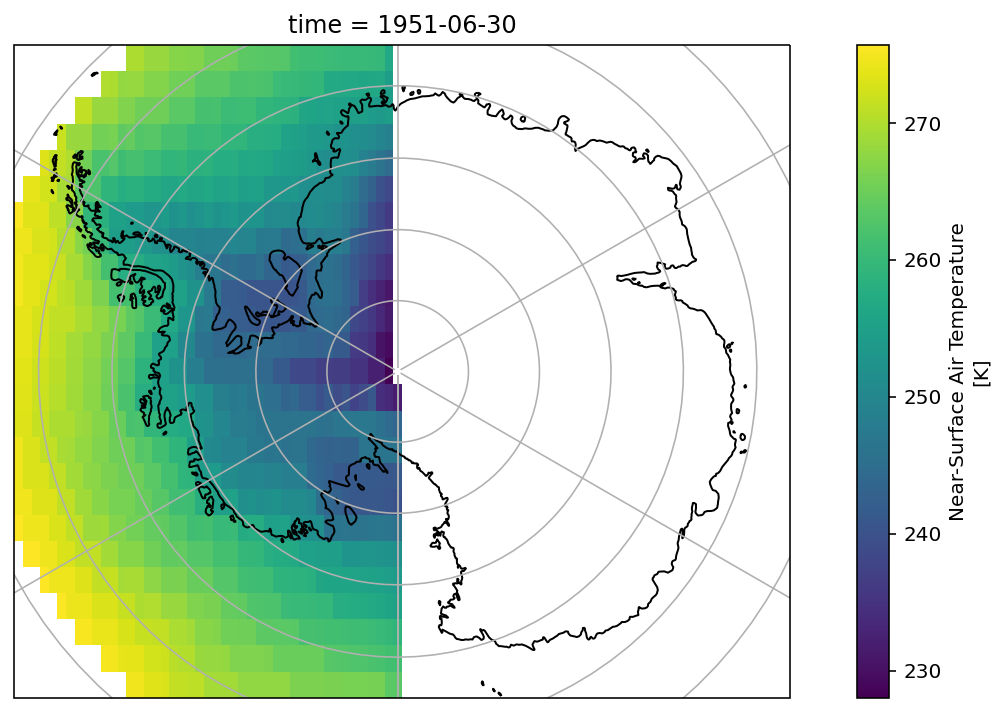

In [29]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_left.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

#### Assemble the two parts:

<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 25, x: 90)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y               (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

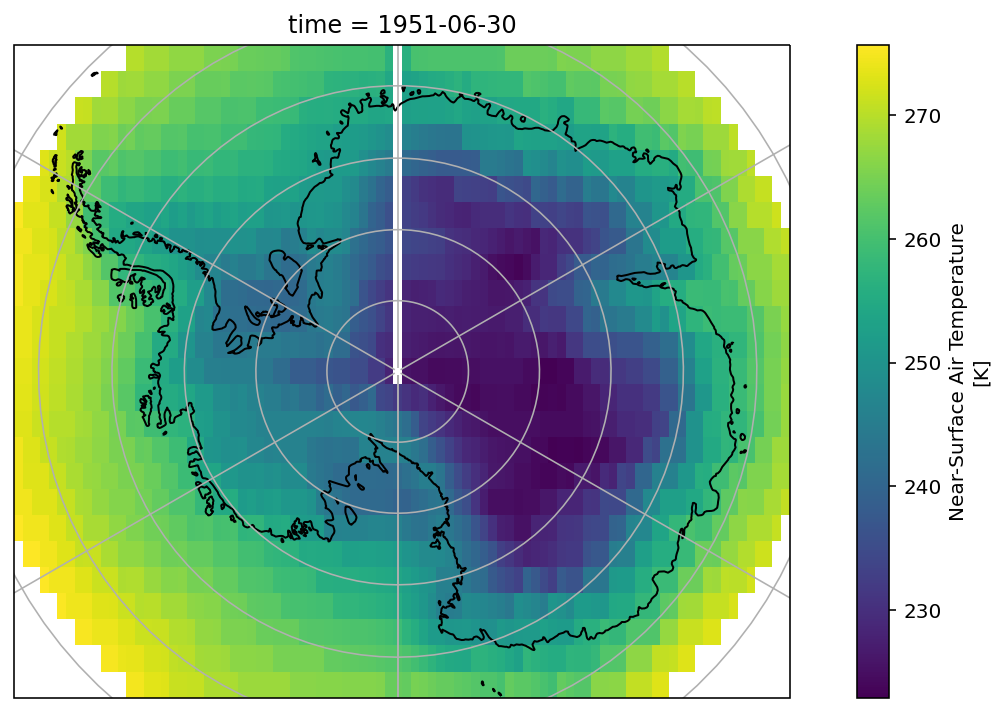

In [30]:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()
GCM_xy.load()

### Save new projection to GC

In [31]:
# Save file
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3-stereographic.zarr'
GCM_xy.attrs['crs'] = 3031
GCM_xy.to_zarr('gs://'+globalName, mode = 'w')

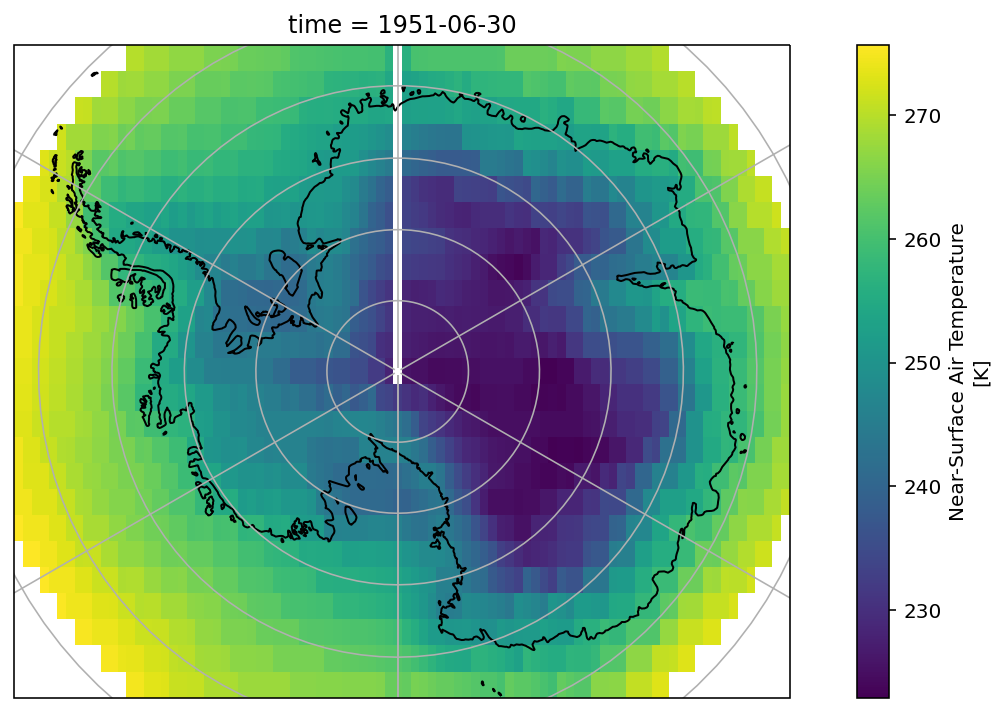

In [32]:
# open from google cloud
dg = xr.open_zarr('gs://'+globalName)
dg.load()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = dg.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

## GCM-like outputs:

### GCM xy:

In [33]:
# open from google cloud
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3-stereographic.zarr'
GCM_xy = xr.open_zarr('gs://'+globalName)
GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
GCM_xy.attrs['crs'] = 3031

Text(0.5, 0.98, 'First time step of GCM_xy (with mean over plevels)')

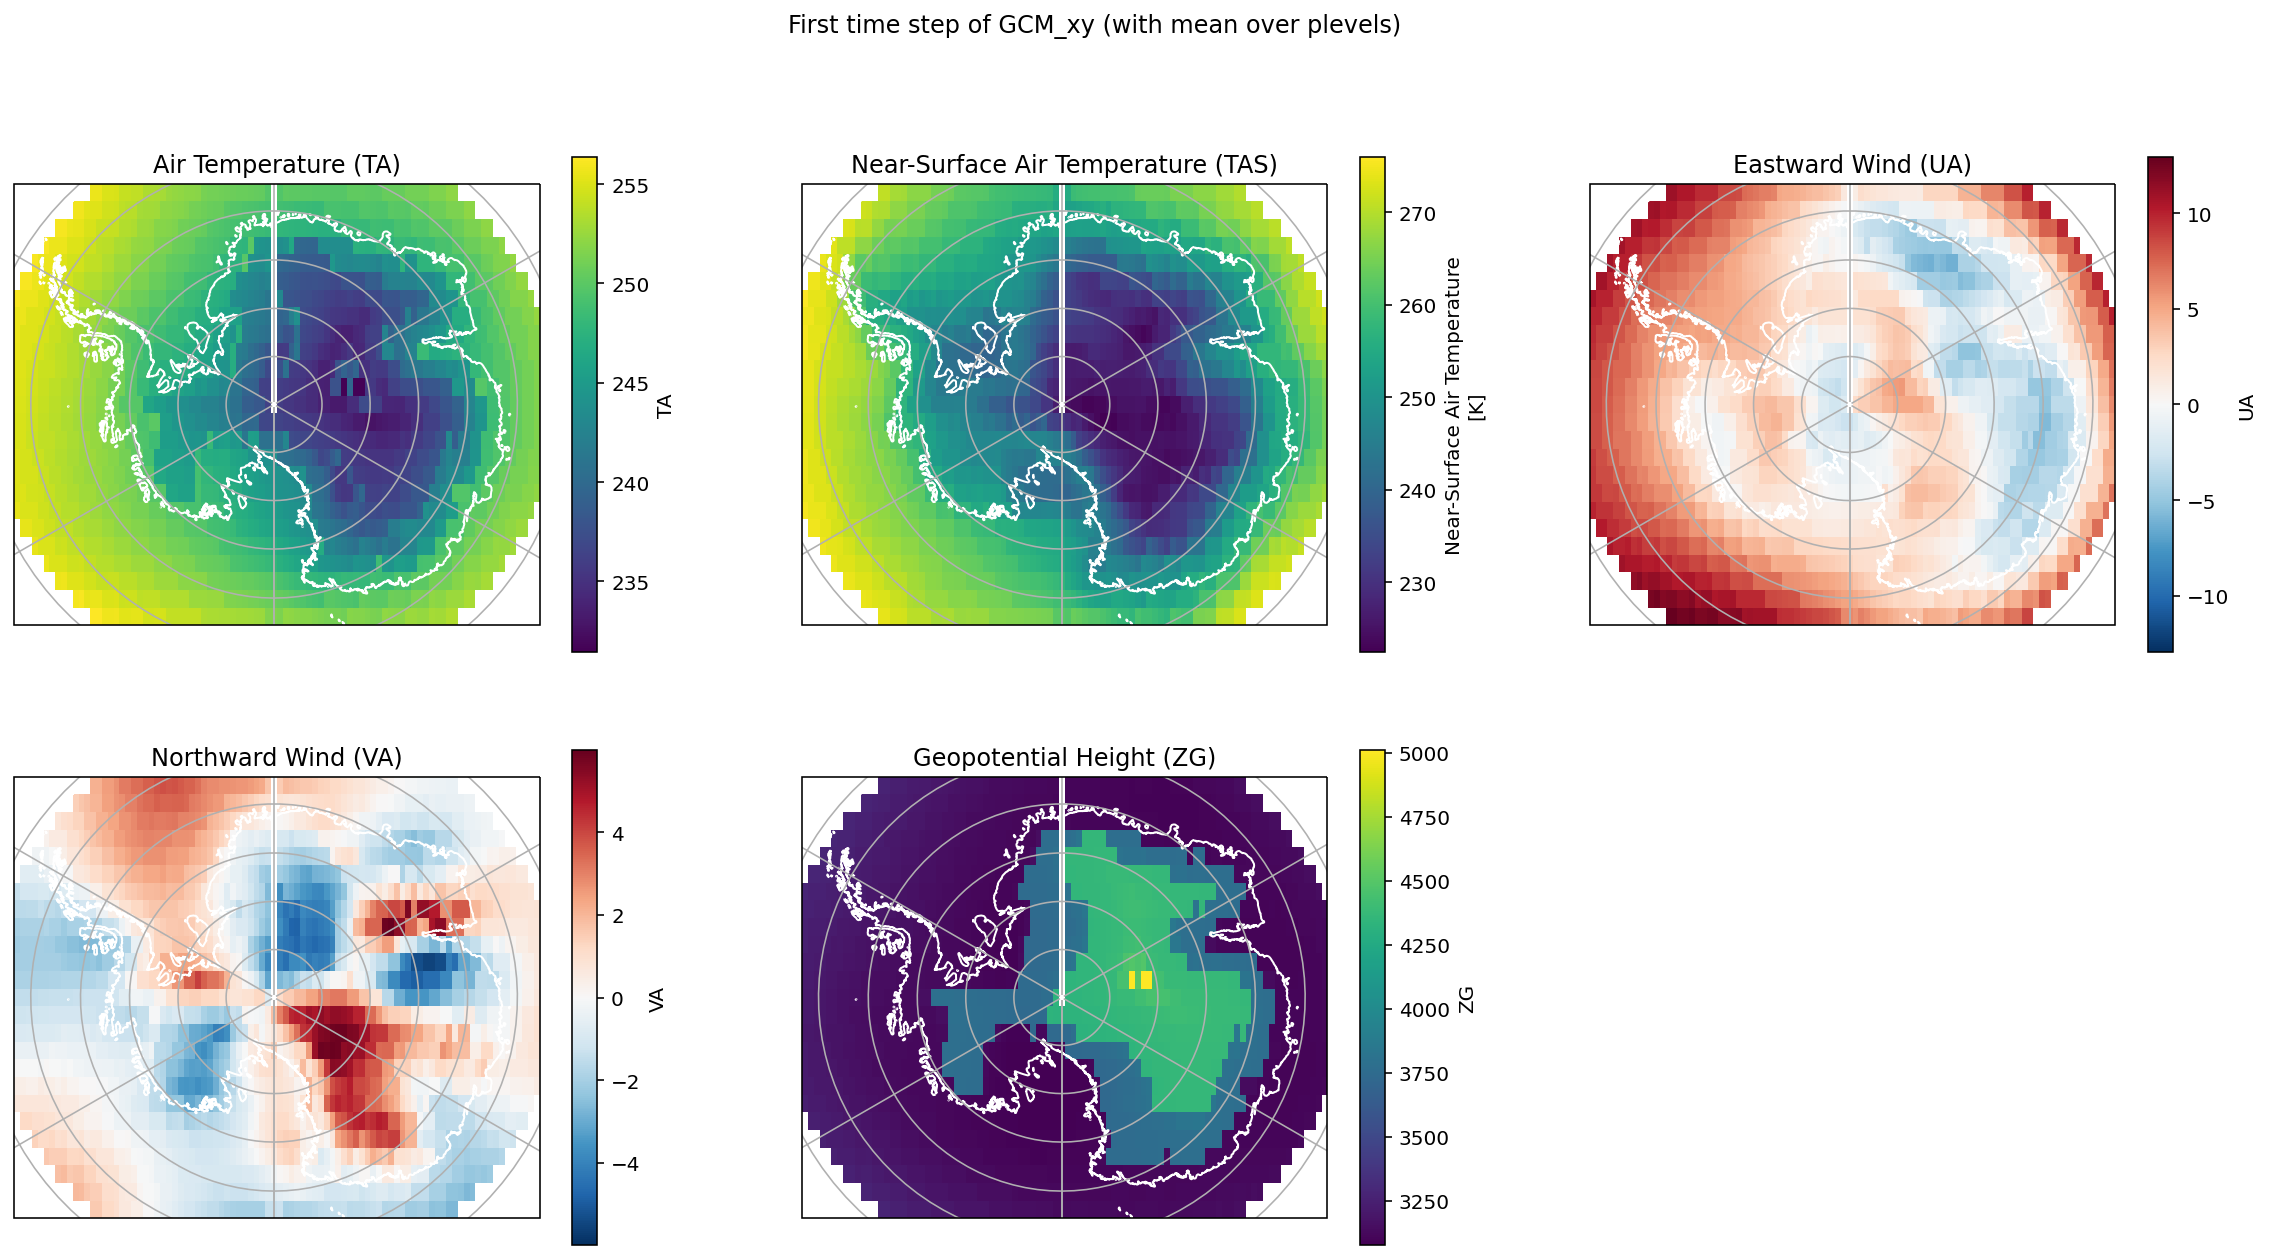

In [34]:
vars_ = ['TA','TAS','UA','VA','ZG']
coords = list(GCM_xy.coords)

# Make mean over all plevels
GCM_xy_plot = GCM_xy.copy()
GCM_xy_plot['TA'] = GCM_xy_plot.TA.mean(dim='plev')
GCM_xy_plot['UA'] = GCM_xy_plot.UA.mean(dim='plev')
GCM_xy_plot['VA'] = GCM_xy_plot.VA.mean(dim='plev')
GCM_xy_plot['ZG'] = GCM_xy_plot.ZG.mean(dim='plev')

# drop irrelevant sector dimension
GCM_xy_plot = GCM_xy_plot.drop_dims('plev')

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(2,3,i+1,projection=ccrs.SouthPolarStereo())
    GCM_xy_plot[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.gridlines()
    ax.set_title(f'{GCM_xy[var].long_name} ({var})')
plt.suptitle('First time step of GCM_xy (with mean over plevels)')

### RCM xy: 
RCM dataset with polar stereographic coordinates:

In [35]:
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
RCM = dsr.rename({'X':'x', 'Y':'y','TIME':'time'})

# indicate projection crs
RCM_xy = RCM.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
RCM_xy['x'] = RCM_xy.x*1000
RCM_xy['y'] = RCM_xy.y*1000
RCM_xy.x.attrs['units'] = 'm'
RCM_xy.y.attrs['units'] = 'm'

# Remove SECTOR dimension:
dim = ('time', 'y', 'x')
RCM_xy['SMB'] = xr.Variable(dims = dim, 
                            data = RCM_xy.SMB.mean(dim='SECTOR1_1'), 
                            attrs = RCM_xy.SMB.attrs)
RCM_xy['RU'] = xr.Variable(dims = dim, 
                           data = RCM_xy.RU.mean(dim='SECTOR1_1'), 
                           attrs = RCM_xy.RU.attrs)
RCM_xy['SU'] = xr.Variable(dims = dim, 
                           data = RCM_xy.SU.mean(dim='SECTOR1_1'), 
                           attrs = RCM_xy.SU.attrs)

# drop irrelevant sector dimension
RCM_xy = RCM_xy.drop_dims('SECTOR1_1')

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(RCM_xy.x.max().data, 
                                                                     RCM_xy.x.min().data, 
                                                                     RCM_xy.y.max().data, 
                                                                     RCM_xy.y.min().data))

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


Text(0.5, 0.98, 'First time step of RCM xy')

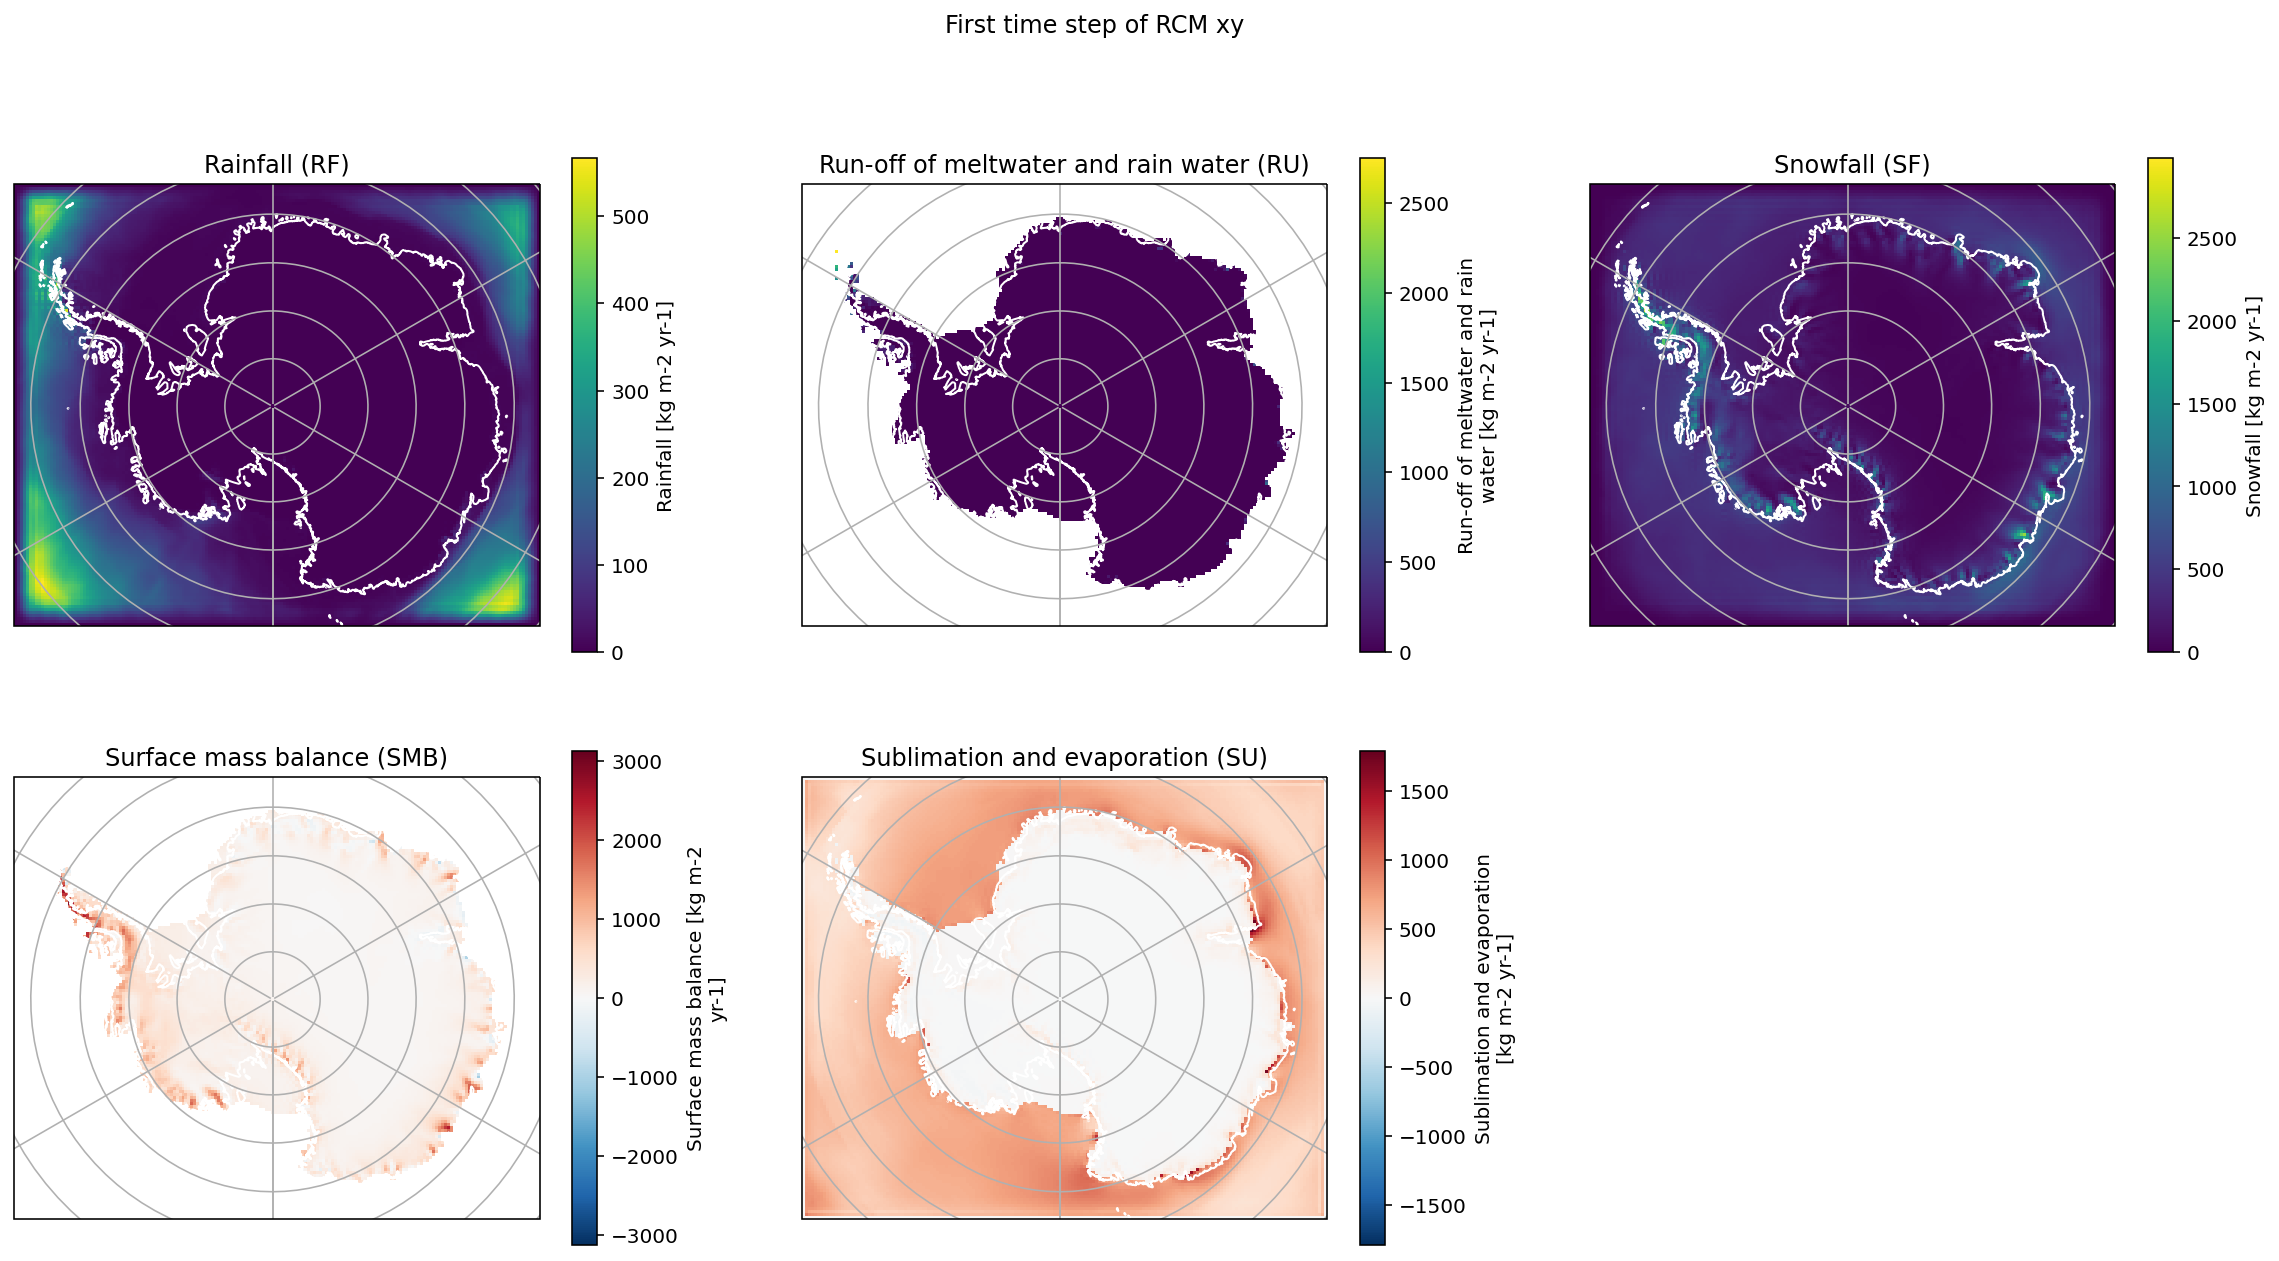

In [36]:
vars_ = list(RCM_xy.keys())[:-1]
coords = list(RCM_xy.coords)

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(2,3,i+1,projection=ccrs.SouthPolarStereo())
    RCM_xy[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.set_title(f'{RCM_xy[var].long_name} ({var})')
    ax.gridlines()
plt.suptitle('First time step of RCM xy')

In [37]:
# Compare resolutions
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.TA)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.SF)

GCM with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.00561797753, 206000.0)
bounds: (-3026000.2528089886, 2575000.0, 3094000.2528089886, -2575000.0)
CRS: EPSG:3031

RCM with crs x/y:
----------------

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
CRS: EPSG:3031



### Reproject RCM xy on GCM xy grid:
Creates fake GCM like outputs from RCM

In [38]:
# Reproject
vars_ = list(RCM_xy.keys())[:-1]

coords = GCM_xy.drop_dims('plev').coords
GCM_like = xr.Dataset()

dim = ('time', 'y', 'x')
for var in vars_:
    GCM_like[var] = xr.Variable(dims = dim, 
                                data = RCM_xy[var].rio.reproject_match(GCM_xy.TA), 
                                attrs = RCM_xy[var].attrs)
GCM_like = GCM_like.assign_coords(RCM_xy[var].rio.reproject_match(GCM_xy.TA).coords)

Text(0.5, 0.98, 'First time step of GCM_like RCM xy')

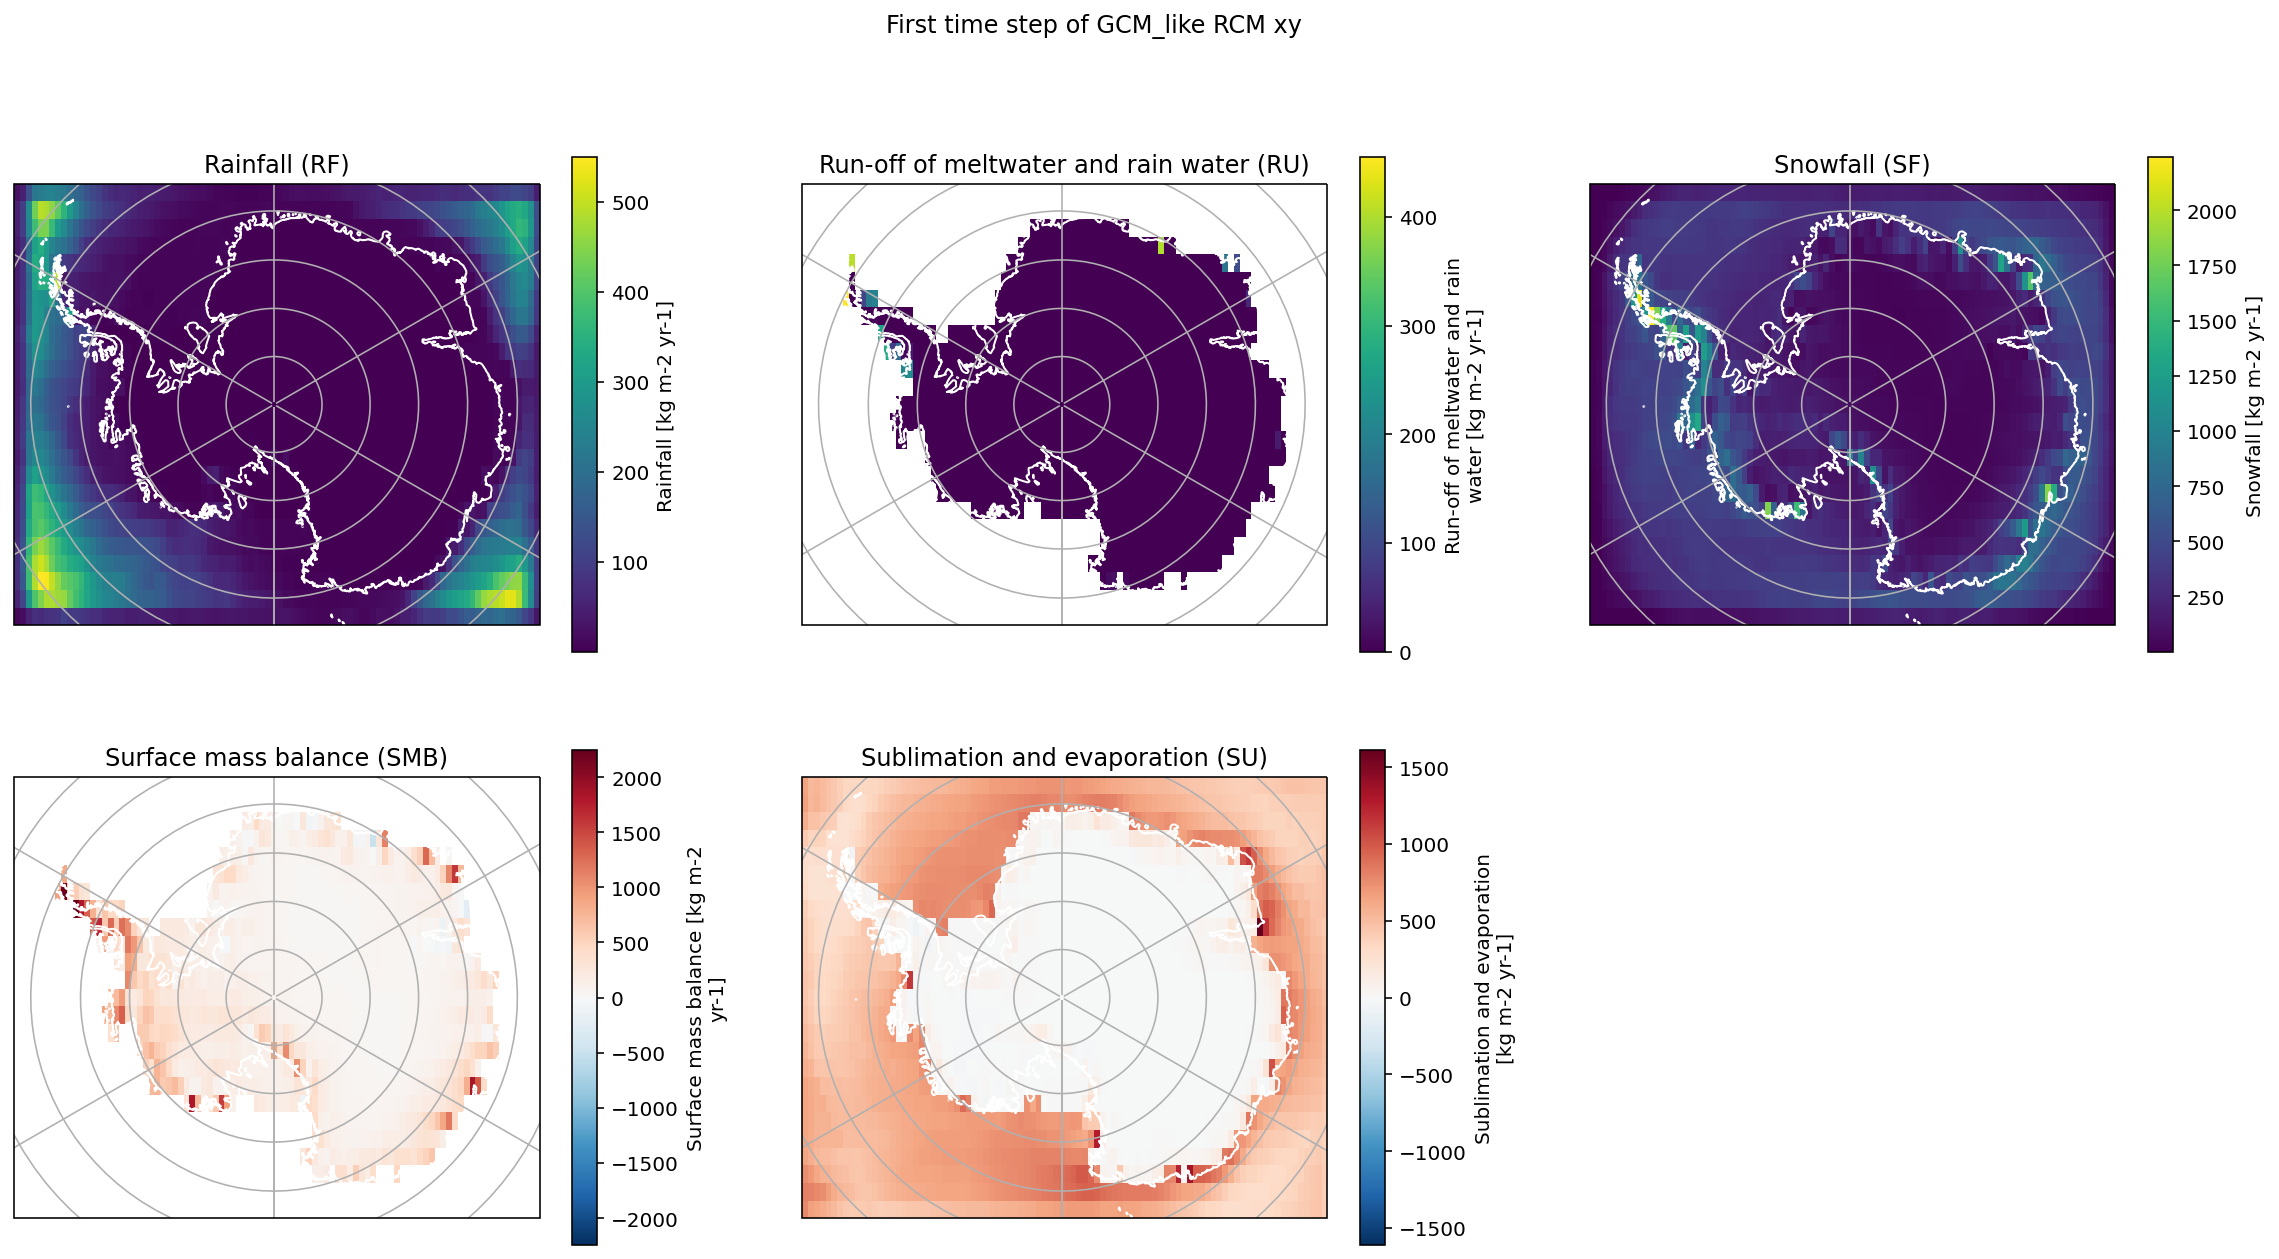

In [39]:
vars_ = list(GCM_like.keys())
coords = list(GCM_like.coords)

f = plt.figure(figsize=(20,10))
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
for i in range(len(vars_)):
    var = vars_[i]
    ax = plt.subplot(2,3,i+1,projection=ccrs.SouthPolarStereo())
    GCM_like[var].isel(time = 0).plot(ax=ax, 
                    x='x', y='y', 
                    transform=ccrs.SouthPolarStereo(),
                    add_colorbar=True
                   )
    ax.coastlines('10m', color='w')
    ax.set_title(f'{RCM_xy[var].long_name} ({var})')
    ax.gridlines()
plt.suptitle('First time step of GCM_like RCM xy')

In [40]:
# Access file
globalName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen-GCMLike.zarr'
GCM_like.attrs['crs'] = 3031
GCM_like.to_zarr('gs://'+globalName, mode = 'w')

In [41]:
print("GCM_like with crs x/y:\n----------------\n")
print_raster(GCM_like)

GCM_like with crs x/y:
----------------

shape: (25, 90)
resolution: (68000.00561797753, 206000.0)
bounds: (-3026000.2528089886, 2575000.0, 3094000.2528089886, -2575000.0)
CRS: EPSG:3031

